In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pykalman import KalmanFilter

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import norm
# import matplotlib.pyplot as plt


def Kalman1D(observations, damping=0):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state

def LCIS(arr):
    """
    求最长连续[递增]*子序列
    返回最长连续递增子序列的
    ---------
    *该[递增]序列并不要求始终严格增，而是最多允许两次递减
    """
    decrease_cnt = 0
    start_index = 0
    end_index = 0
    sub_len = 0
    longest_start = 0
    longest_end = 0
    longest_len = 0
    decrease_point_0 = -1
    decrease_point_1 = -1
    for i in range(1, len(arr)):
        if arr[i] > arr[i-1]:
            end_index += 1
        else:
            decrease_cnt += 1
            if decrease_cnt == 1:
                end_index += 1
                decrease_point_0 = end_index
            elif decrease_cnt == 2:
                end_index += 1
                decrease_point_1 = end_index
            else:
                sub_len = end_index - start_index + 1
                if longest_len < sub_len:
                    longest_len = sub_len
                    longest_start = start_index
                    longest_end = end_index
                start_index = decrease_point_0
                decrease_point_0 = decrease_point_1
                decrease_point_1 = i
                end_index = i
                decrease_cnt = 2

    sub_len = end_index - start_index + 1
    if longest_len < sub_len:
        longest_len = sub_len
        longest_start = start_index
        longest_end = end_index

    return longest_start, longest_end


def mlesigma(f_name, st_indx, end_indx):
    """
    我们引入 MLE 方法来估计忆阻器电导值与对应电压水平下电导均值的比值的 mu 和 sigma
    函数返回 sigma 值，它的值反映了等效噪声水平的强度
    '''
    关于噪声分布形式设定与转换的说明：
    X ~ logNorm(a, b)  # m, v 是对数正态分布本身的均值和方差
    # 这说的是 X 是一个值永远为正的随机变量，只有取对数之后才是正态分布
    即 logX ~ Norm(mu, sigma)

    换算关系：
    m = exp(mu + sigma^2/2)  # 注意到 m 是 >0 的
    v = exp(2*mu + sigma^2) * exp(sigma^2 - 1)  

    因此，一个随机变量 Y 如果服从正态分布，即 Y ~ Norm(mu, sigma)
    就一定可以有一个 X = exp(Y), 使得 Y = logX ~ Norm(mu, sigma)

    所以，一个正态分布随机变量取指数得到的变量就服从对数正态分布

    具体到上面的代码，已知gaussian_kernel 服从正态分布，则 
            torch.exp(noise_sigma*gassian_kernel.sample(noise_sigma.size())) 
    服从对数正态分布，其中我们施加的 mu, sigma 都是对应的正态分布的参数，而非对数正态分布的参数

    又由于 (m, v) 和 (mu, sigma) 是一一映射，我们控制谁都一样，
    所以，为了方便和统一，今后：
    1）需要采样对数正态分布样本，都采取先用 mu, sigma 采样正态分布，再 exp 的方式
    2）需要估计对数正态分布参数，都采取先对对数正态分布样本取 log，再用 norm.fit 拟合的方式
    '''
    """
    eps = 1e-12
    data = pd.read_excel(f_name, engine='openpyxl').iloc[st_indx: end_indx+1, :]
    # data = data.iloc[st_indx: end_indx+1, :]
    
    conductance = data.drop(['voltage'], axis=1).div((data['voltage']+eps), axis=0)
    # conductance = conductance[(conductance!=np.inf).all(axis=1)]
    
    conductance_by_mean = np.array(conductance.div(conductance.mean(axis=1), axis=0)).reshape(1, -1)[0]
    samples = np.log(conductance_by_mean + eps)
    samples_fine = np.delete(conductance_by_mean, np.isfinite(samples)==False)

    mu_hat, sigma_hat = norm.fit(samples_fine)  # 通过极大似然估计得到 sigma\hat，不固定均值为 0
    # mu_hat, sigma_hat = norm.fit(samples_fine, floc=0)  # 通过极大似然估计得到 sigma\hat，固定均值为 0
    return mu_hat, sigma_hat


from scipy.stats import chi2

def mlesigma_with_CI(f_name, st_indx, end_indx):
    eps = 1e-12
    data = pd.read_excel(f_name, engine='openpyxl').iloc[st_indx: end_indx+1, :]
    # data = data.iloc[st_indx: end_indx+1, :]
    
    conductance = data.drop(['voltage'], axis=1).div((data['voltage']+eps), axis=0)
    # conductance = conductance[(conductance!=np.inf).all(axis=1)]
    
    conductance_by_mean = np.array(conductance.div(conductance.mean(axis=1), axis=0)).reshape(1, -1)[0]
    samples = np.log(conductance_by_mean + eps)
    samples_fine = np.delete(conductance_by_mean, np.isfinite(samples)==False)

    mu_hat, sigma_hat = norm.fit(samples_fine)  # 通过极大似然估计得到 sigma\hat，不固定均值为 0
    # mu_hat, sigma_hat = norm.fit(samples_fine, floc=0)  # 通过极大似然估计得到 sigma\hat，固定均值为 0
    sigma_hat_upper95 = sigma_hat * np.sqrt((end_indx-st_indx+1) / chi2.ppf(q=0.005, df=end_indx-st_indx))
    
    return mu_hat, sigma_hat, sigma_hat_upper95


def calculate_smoothed_cmean(f_name):
    df = pd.read_excel(f_name, engine='openpyxl')
    eps = 1e-12
    current_cols = df.iloc[:, 1:]
    voltage_col = df.iloc[:, :1].values

    conductance_cols = current_cols.div(voltage_col + eps)
    conductance_mean_col = conductance_cols.mean(axis=1).values
    conductance_mean_col_head100 = conductance_mean_col[1: 101]
    c_mean_smooth = Kalman1D(conductance_mean_col_head100)
    # c_mean_smooth = c_mean_smooth.T[0]
    return c_mean_smooth

def get_usability_with_sigma(file_name):
    eps = 1e-12
    df = pd.read_excel(file_name, engine='openpyxl')

    c_mean_smooth = calculate_smoothed_cmean(file_name)#= Kalman1D(c_std_smooth,damping=1)

    longest_start, longest_end = LCIS(c_mean_smooth)
    # c_mean_smooth, c_std_smooth = mlesigma(file_name, longest_start, longest_end+1)
    c_mean_smooth, c_std_smooth, sigma_hat_upper95 = mlesigma_with_CI(file_name, longest_start, longest_end+1)
    
    usability = (longest_end - longest_start) / 100. * (1 - c_std_smooth / c_mean_smooth)
    return usability, c_std_smooth, sigma_hat_upper95


# get_usability('./hardware_data/I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx')
# get_usability('./hardware_data/I-V_data_2.5um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_silver_paste.xlsx')

In [2]:
import os
from tqdm import tqdm


# dir_name = './data_added0709/'#'./hardware_data/'

dir_name = './hardware_IV_and_condition_summary/hardware_data/'

dirs = sorted(os.listdir(dir_name))

file2usability = {}
file2sigma = {}
file2sigma_upper = {}

for f_name in tqdm(dirs):
    if not f_name.endswith('.xlsx'):
        continue
    res = get_usability_with_sigma(dir_name+f_name)
    file2usability[f_name] = res[0]
    file2sigma[f_name] = res[1]
    file2sigma_upper[f_name] = res[2]
    
file2usability, file2sigma, file2sigma_upper

100%|██████████| 43/43 [01:10<00:00,  1.64s/it]


({'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste_no_wait.xlsx': -0.20327452853183445,
  'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe_no_wait.xlsx': 0.22273483703421348,
  'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste_no_wait.xlsx': -0.26501115457282065,
  'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste_no_wait.xlsx': -0.15865615371830316,
  'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste_no_wait.xlsx': -0.04481165090987748,
  'I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe_no_wait.xlsx': 0.3634794973438098,
  'I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_10

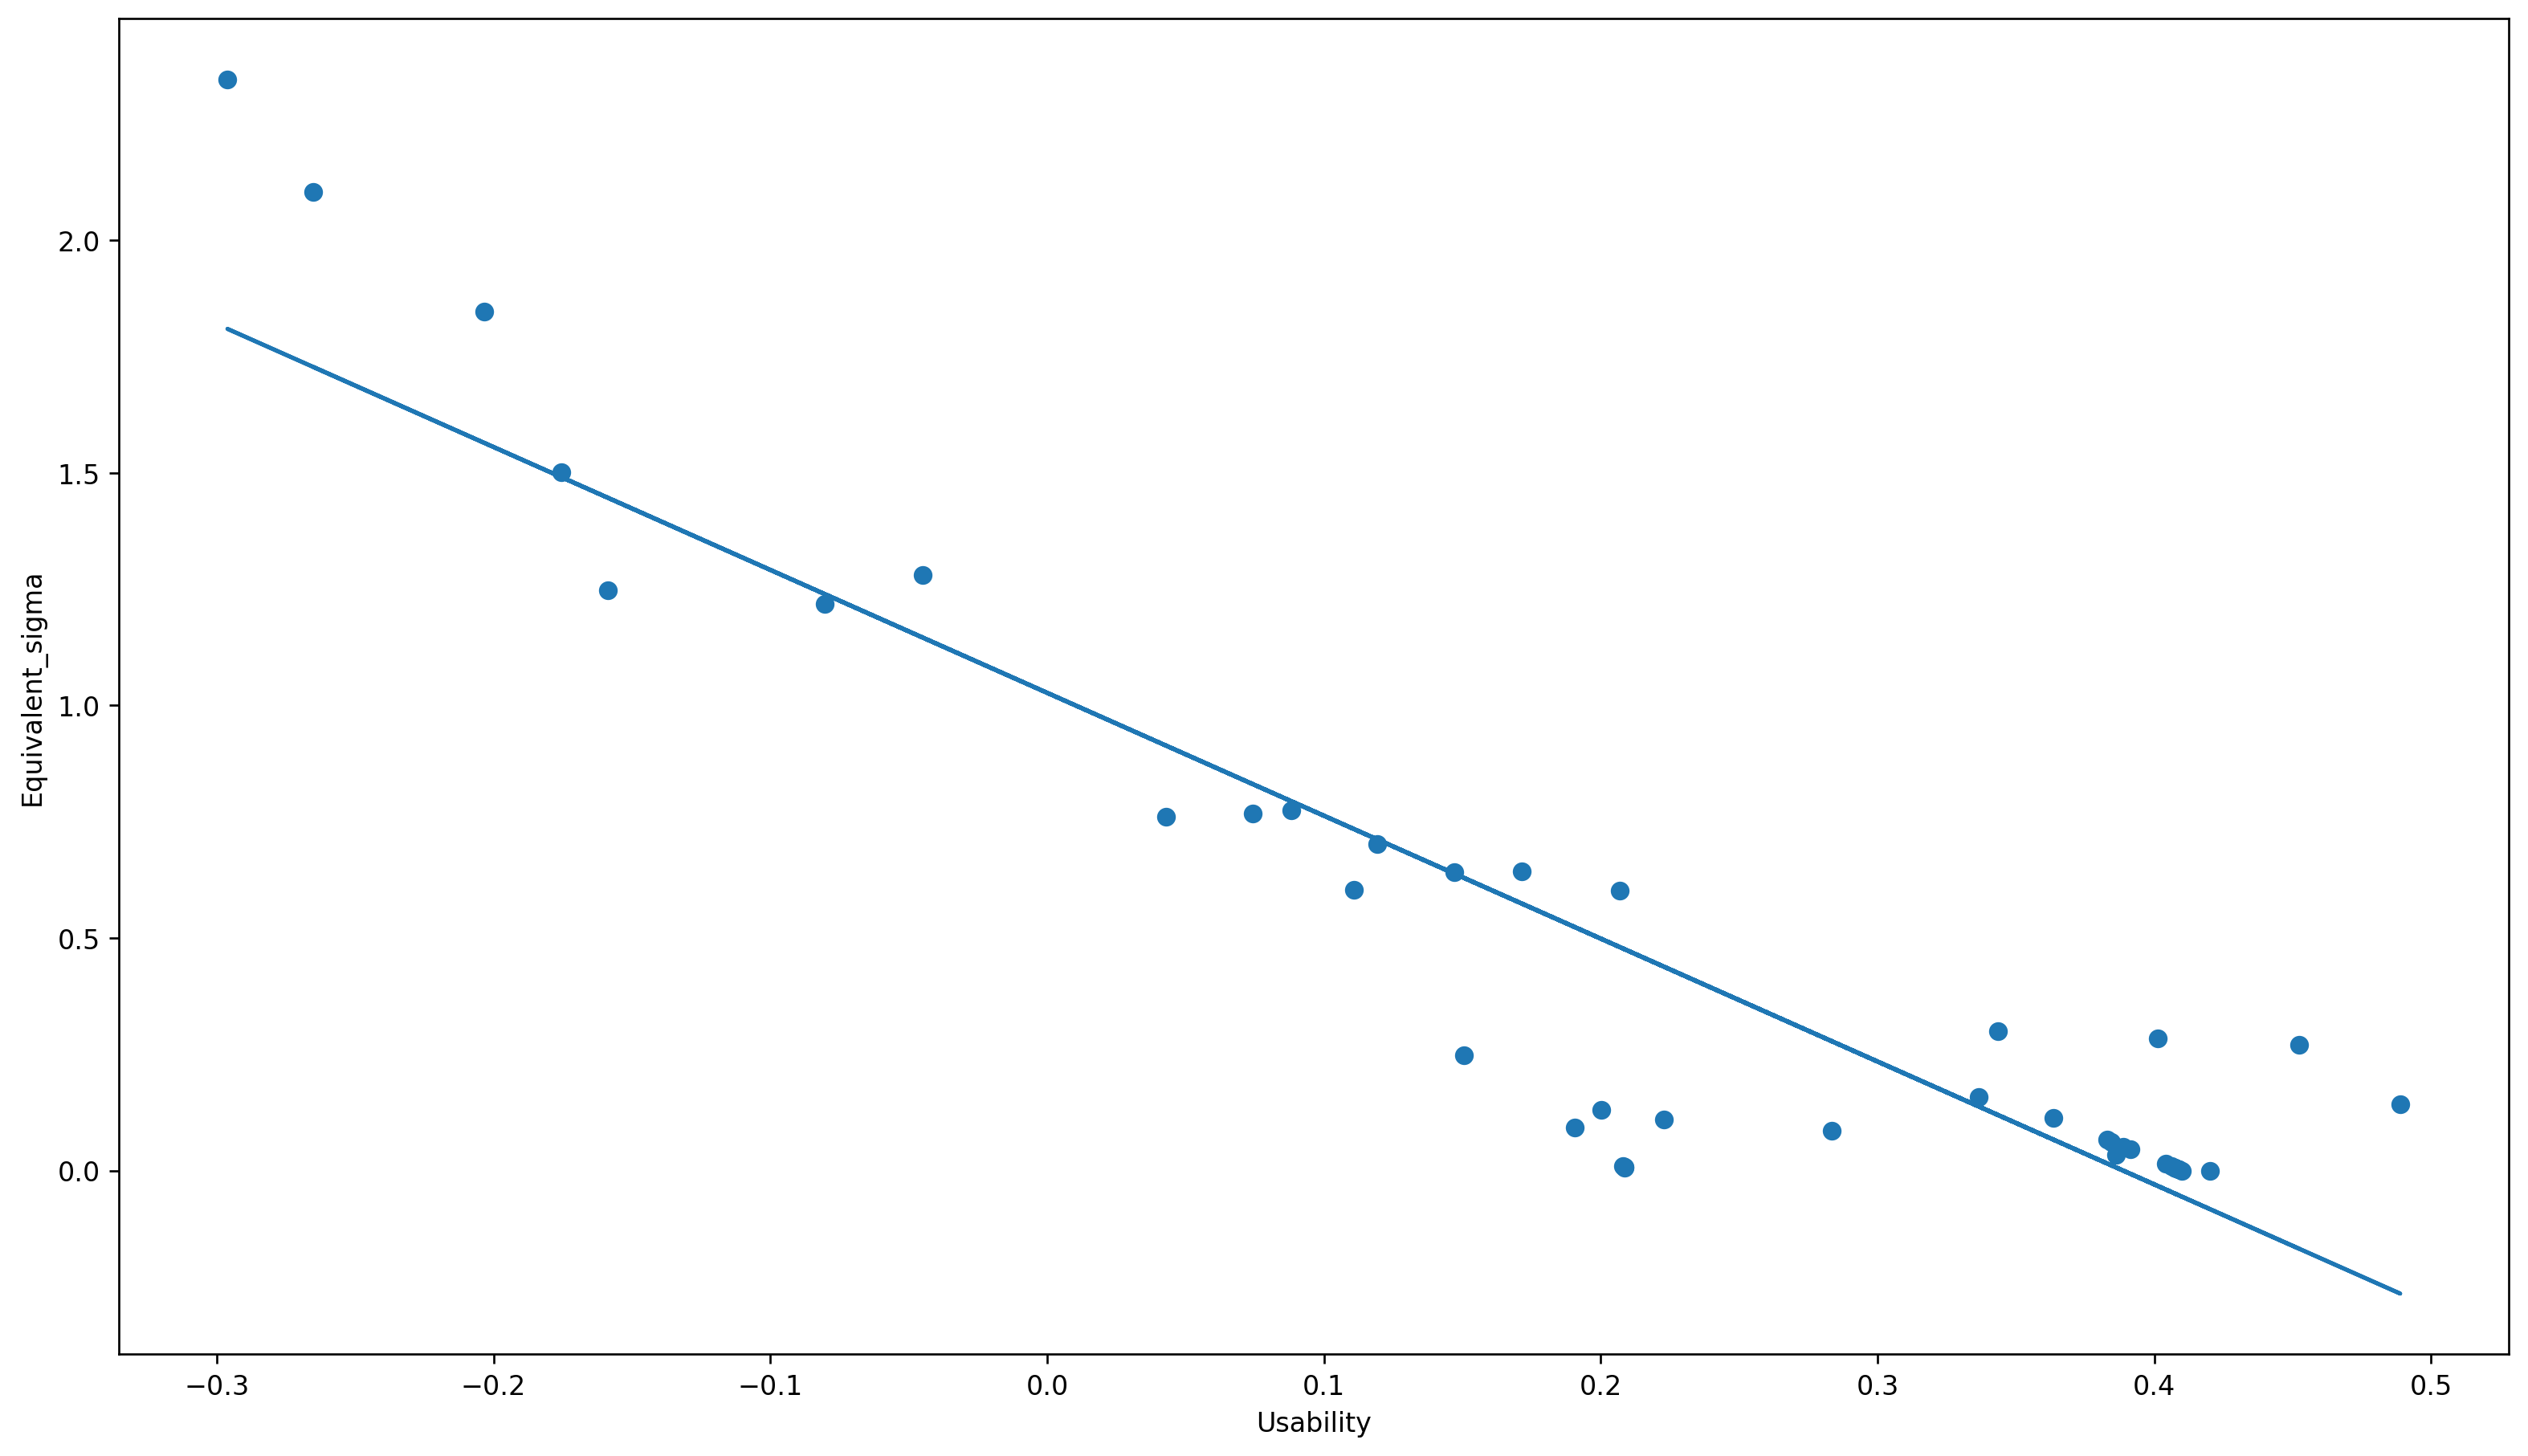

In [3]:
from matplotlib import pyplot as plt

x = np.array(list(file2usability.values()))
y = np.array(list(file2sigma.values()))

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
sigma_hat = p(x)

plt.figure(dpi=240,figsize=(16, 9))
plt.scatter(x, y)
plt.plot(file2usability.values(), sigma_hat)
plt.xlabel('Usability')
plt.ylabel('Equivalent_sigma')
plt.show()

(array([ 2.,  3.,  1.,  1.,  3.,  5.,  7.,  1., 17.,  3.]),
 array([-0.29608158, -0.21759529, -0.13910901, -0.06062272,  0.01786357,
         0.09634986,  0.17483615,  0.25332244,  0.33180873,  0.41029502,
         0.48878131]),
 <BarContainer object of 10 artists>)

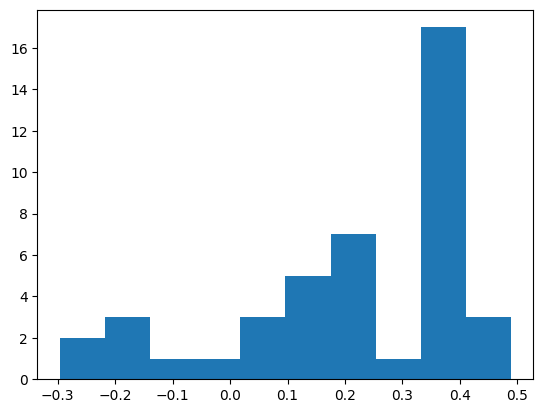

In [4]:
plt.hist(file2usability.values(), bins=10)

(array([24.,  4.,  5.,  3.,  0.,  3.,  1.,  1.,  1.,  1.]),
 array([1.37000229e-16, 2.34582538e-01, 4.69165076e-01, 7.03747614e-01,
        9.38330152e-01, 1.17291269e+00, 1.40749523e+00, 1.64207777e+00,
        1.87666030e+00, 2.11124284e+00, 2.34582538e+00]),
 <BarContainer object of 10 artists>)

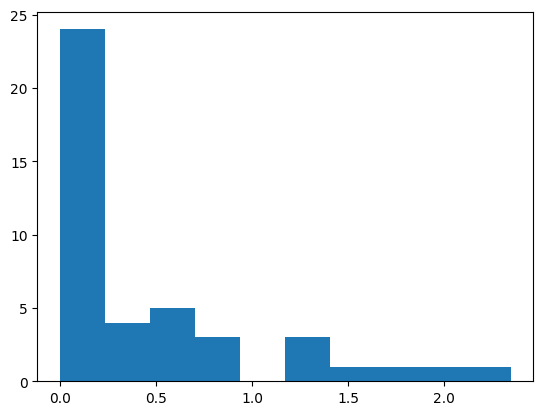

In [5]:
plt.hist(file2sigma.values(), bins=10)

In [6]:
np.save('file2usability.npy', file2usability)
np.save('file2sigma.npy', file2sigma)
np.save('file2sigma_upper.npy', file2sigma_upper)

In [7]:
sigma2sigma_upper = {}
for f in file2sigma.keys():
    sigma = file2sigma[f]
    sigma_upper = file2sigma_upper[f]
    sigma2sigma_upper[sigma] = sigma_upper
sigma2sigma_upper

{1.8469772022159765: 2.903671754065915,
 0.10906065186314605: 0.1696341373668554,
 2.1042131440534195: 3.3080777952167058,
 1.2479002401848487: 1.6154616844754965,
 1.2800728181867342: 2.275304593205917,
 0.11346464062485402: 0.15813246241823042,
 0.002659952221105319: 0.003707100223662887,
 0.014474517297733476: 0.02017272561743338,
 0.05186920595483783: 0.07228864619098069,
 1.5010752566933228: 2.1589266882231417,
 0.6426642689467759: 0.8705447295065399,
 0.034563685795860666: 0.04839796332251017,
 0.006552443852351946: 0.009131955783964677,
 0.045186830120836324: 0.06297560787688174,
 0.06579636794072251: 0.09169853818197601,
 0.09235709242649176: 0.15066384231134444,
 0.009097429143701681: 0.012678829847311925,
 0.760636499258092: 1.3002835390931557,
 0.003065681896698354: 0.0042725542040778445,
 0.006720265700331256: 0.00936584434979805,
 0.14248893145556166: 0.18767834632910257,
 0.641237383816028: 0.8936744164440692,
 0.009127350771256844: 0.014889617041760804,
 0.08531171444790

In [8]:
file2usability = np.load('./file2usability.npy', allow_pickle=True).item()
file2sigma = np.load('./file2sigma.npy', allow_pickle=True).item()

In [9]:
file2usability

{'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste_no_wait.xlsx': -0.20327452853183445,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe_no_wait.xlsx': 0.22273483703421348,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste_no_wait.xlsx': -0.26501115457282065,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste_no_wait.xlsx': -0.15865615371830316,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste_no_wait.xlsx': -0.04481165090987748,
 'I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe_no_wait.xlsx': 0.3634794973438098,
 'I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_10h_180+2

In [10]:
file2sigma

{'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste_no_wait.xlsx': 1.8469772022159765,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe_no_wait.xlsx': 0.10906065186314605,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste_no_wait.xlsx': 2.1042131440534195,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste_no_wait.xlsx': 1.2479002401848487,
 'I-V_data_0.7um_length_200nm_diameter_BT_4V_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste_no_wait.xlsx': 1.2800728181867342,
 'I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe_no_wait.xlsx': 0.11346464062485402,
 'I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI

In [11]:
# np.load('file2usability.npy', allow_pickle=True).item()#)#[0]#.todict()#['I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx']

In [12]:
for i, j in sorted(zip(file2sigma.values(), file2sigma.keys())):
    print(i, j)


1.3700022894417224e-16 I-V_data_1.5um_length_5nm_diameter_BT_4V_NA_third_etch_8min_Pb_ED_3h_180C_MAI_no_150nm_Ag_memory_6V_carbon_paste_no_wait.xlsx
8.30265600420149e-06 I-V_data_1.8um_length_50nm_diameter_BT_4V_NA_third_etch_20min_Pb_ED_3h_180C_MAI_no_200nm_Ag_memory_6V_carbon_paste_no_wait.xlsx
0.002659952221105319 I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_silver_paste_no_wait.xlsx
0.003065681896698354 I-V_data_1.2um_length_250nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_3h_180C_MAI_PMMA_600nm_Ag_memory_6V_carbon_paste_no_wait.xlsx
0.004893866123810633 I-V_data_2um_length_250nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_3h_180C_MAI_no_200nm_Ag_memory_6V_carbon_paste_no_wait.xlsx
0.006552443852351946 I-V_data_1.2um_length_200nm_diameter_BT_4V_NA_third_etch_15min_Pb_ED_3h_210C_MABr_PMMA_200nm_Ag_memory_6V_silver_paste_no_wait.xlsx
0.006588873912809546 I-V_data_1um_length_200nm_diameter_BT_4V_NA_third_etch_10min_Pb_ED_1h_1

sigma CI

In [13]:
from scipy.stats import chi2

def mlesigma_with_CI(f_name, st_indx, end_indx):
    """
    我们引入 MLE 方法来估计忆阻器电导值与对应电压水平下电导均值的比值的 mu 和 sigma
    函数返回 sigma 值，它的值反映了等效噪声水平的强度
    '''
    关于噪声分布形式设定与转换的说明：
    X ~ logNorm(a, b)  # m, v 是对数正态分布本身的均值和方差
    # 这说的是 X 是一个值永远为正的随机变量，只有取对数之后才是正态分布
    即 logX ~ Norm(mu, sigma)

    换算关系：
    m = exp(mu + sigma^2/2)  # 注意到 m 是 >0 的
    v = exp(2*mu + sigma^2) * exp(sigma^2 - 1)  

    因此，一个随机变量 Y 如果服从正态分布，即 Y ~ Norm(mu, sigma)
    就一定可以有一个 X = exp(Y), 使得 Y = logX ~ Norm(mu, sigma)

    所以，一个正态分布随机变量取指数得到的变量就服从对数正态分布

    具体到上面的代码，已知gaussian_kernel 服从正态分布，则 
            torch.exp(noise_sigma*gassian_kernel.sample(noise_sigma.size())) 
    服从对数正态分布，其中我们施加的 mu, sigma 都是对应的正态分布的参数，而非对数正态分布的参数

    又由于 (m, v) 和 (mu, sigma) 是一一映射，我们控制谁都一样，
    所以，为了方便和统一，今后：
    1）需要采样对数正态分布样本，都采取先用 mu, sigma 采样正态分布，再 exp 的方式
    2）需要估计对数正态分布参数，都采取先对对数正态分布样本取 log，再用 norm.fit 拟合的方式
    '''
    """
    eps = 1e-12
    data = pd.read_excel(f_name, engine='openpyxl').iloc[st_indx: end_indx+1, :]
    # data = data.iloc[st_indx: end_indx+1, :]
    
    conductance = data.drop(['voltage'], axis=1).div((data['voltage']+eps), axis=0)
    # conductance = conductance[(conductance!=np.inf).all(axis=1)]
    
    conductance_by_mean = np.array(conductance.div(conductance.mean(axis=1), axis=0)).reshape(1, -1)[0]
    samples = np.log(conductance_by_mean + eps)
    samples_fine = np.delete(conductance_by_mean, np.isfinite(samples)==False)

    mu_hat, sigma_hat = norm.fit(samples_fine)  # 通过极大似然估计得到 sigma\hat，不固定均值为 0
    # mu_hat, sigma_hat = norm.fit(samples_fine, floc=0)  # 通过极大似然估计得到 sigma\hat，固定均值为 0
    sigma_hat_upper95 = sigma_hat * np.sqrt((end_indx-st_indx+1) / chi2.ppf(q=0.005, df=end_indx-st_indx))
    
    return mu_hat, sigma_hat, sigma_hat_upper95

In [14]:
mlesigma_with_CI(f_name='I-V_data_25min_AAO_10min_Pb_ED_1h_180C_MAI_memory_8V_2.xlsx', st_indx=0, end_indx=100)

(1.0, 0.18021548046445335, 0.22072744309852402)

In [15]:
# for f_name in 

In [21]:
def get_usability_st_end(file_name):
    eps = 1e-12
    df = pd.read_excel(file_name, engine='openpyxl')

    c_mean_smooth = calculate_smoothed_cmean(file_name)#= Kalman1D(c_std_smooth,damping=1)

    longest_start, longest_end = LCIS(c_mean_smooth)
    print(longest_start, longest_end)
    # c_mean_smooth, c_std_smooth = mlesigma(file_name, longest_start, longest_end+1)
    c_mean_smooth, c_std_smooth, sigma_hat_upper95 = mlesigma_with_CI(file_name, longest_start, longest_end+1)
    
    usability = (longest_end - longest_start) / 100. * (1 - c_std_smooth / c_mean_smooth)
    return usability, c_std_smooth, sigma_hat_upper95

# sunqiao/OpenPCDet/tools/hardware_noise/hardware_IV_and_condition_summary/hardware_data
get_usability_st_end('hardware_IV_and_condition_summary/hardware_data/\
                     I-V_data_1.5um_length_5nm_diameter_BT_4V_NA_third_etch_8min_Pb_ED_3h_180C_MAI_no_150nm_Ag_memory_6V_carbon_paste_no_wait.xlsx')

57 99


(0.41999999999999993, 1.3700022894417224e-16, 1.9007041307276222e-16)

In [16]:
# get_usability_with_sigma('I-V_data_25min_AAO_10min_Pb_ED_1h_180C_MAI_memory_8V_2.xlsx')

In [17]:
# get_usability_with_sigma('I-V_data_30min_AAO_5min second etch_15min_Pb_ED_3h_180C_MAI_200nm_Ag_memory_6V.xlsx')

In [18]:
# get_usability_with_sigma('I-V_data_25min_AAO_10min_Pb_ED_1h_180C_MAI_memory_8V.xlsx')